# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup posts on a variety of topics. You'll train classifiers to distinguish posts by topics inferred from the text. Whereas with digit classification, where each input is relatively dense (represented as a 28x28 matrix of pixels, many of which are non-zero), here each document is relatively sparse (represented as a bag-of-words). Only a few words of the total vocabulary are active in any given document. The assumption is that a label depends only on the count of words, not their order.

The `sklearn` documentation on feature extraction may be useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on Slack, but <b> please prepare your own write-up with your own code. </b>

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Part 1:

For each of the first 5 training examples, print the text of the message along with the label.

In [3]:
def P1(num_examples=5):

    ### STUDENT START ###
    
    # range over the number of examples
    for i in range(num_examples):
        # create a string to identify the article label
        label = "Label: " + newsgroups_train.target_names[train_labels[i]]
        
        # create a string separator to be used to separate each example
        sep = '=' * len(label)
        
        # print the example
        print(sep)
        print('Example:', i+1)
        print(label)
        print(sep)
        print(train_data[i], "\n\n")
        
    ### STUDENT END ###

P1(5)

Example: 1
Label: comp.graphics
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych 


Example: 2
Label: talk.religion.misc


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for 

### Part 2:

Transform the training data into a matrix of **word** unigram feature vectors.  What is the size of the vocabulary? What is the average number of non-zero features per example?  What is the fraction of the non-zero entries in the matrix?  What are the 0th and last feature strings (in alphabetical order)?<br/>
_Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._

Now transform the training data into a matrix of **word** unigram feature vectors using your own vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. What is the average number of non-zero features per example?<br/>
_Use `CountVectorization(vocabulary=...)` and its `.transform` method._

Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  What is the size of the vocabulary?<br/>
_Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._

Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  What is the size of the vocabulary?<br/>
_Use `CountVectorization(min_df=...)` and its `.fit_transform` method._

Now again transform the training data into a matrix of **word** unigram feature vectors. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?<br/>
_Hint: Build vocabularies for both train and dev and look at the size of the difference._

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html.  

In [4]:
   
def P2():

    ### STUDENT START ###
    
    def feature_vector_stats(cv, feature_vector):
        # What is the size of the vocabulary? 
        size = feature_vector.shape[1]
        print('Vocabulary size: {}'.format(size))

        # What is the average number of non-zero features per example?
        examples = feature_vector.shape[0]
        nz = feature_vector.nnz
        print('Average number of non-zero entries per example: {:.4f}'.format(nz/examples))

        # What is the fraction of the non-zero entries in the matrix?     
        vocab = feature_vector.shape[1]
        matrix = examples * vocab
        print('Fraction of non-zero entries in matrix: {:.4f}'.format(nz/matrix))

        # What are the 0th and last feature strings (in alphabetical order)?
        first =  cv.get_feature_names()[0]
        last =  cv.get_feature_names()[-1]
        print('First feature string: {}'.format(first))
        print('Last feature string: {}\n'.format(last))
    
    def p2_1(data):
        print('Part 2.1\n{}'.format('='*20))

        # Initialize a CountVectorizer object
        cv = CountVectorizer()

        # Transform the data into a feature vector
        feature_vector = cv.fit_transform(data)
        feature_vector_stats(cv, feature_vector)


    def p2_2(data):
        print('Part 2.2\n{}'.format('='*20))

        # Assigen variable for custom vocabulary
        vocabulary = ["atheism", "graphics", "space", "religion"]

        # Initialize a CountVectorizer object with custom vocabulary
        cv = CountVectorizer(vocabulary=vocabulary)

        # Transform the train_data into a feature vector
        feature_vector = cv.transform(train_data)
        feature_vector_stats(cv, feature_vector)

    def p2_3(data):
        print('Part 2.3\n{}'.format('='*20))
        
        # Create a CountVectorizer object that produces 2-grams and 3-grams only
        cv = CountVectorizer(analyzer='char', ngram_range=(2,3))
        
        # Transform the train_data into a feature vector
        feature_vector = cv.fit_transform(data)
        feature_vector_stats(cv, feature_vector)

    def p2_4(data):
        print('Part 2.4\n{}'.format('='*20))
        
        # Create a CountVectorizer object that prunes words that appear in fewer than 10 documents
        cv = CountVectorizer(min_df=10)
        
        # Transform the train_data into a feature vector
        feature_vector = cv.fit_transform(data)
        feature_vector_stats(cv, feature_vector)
        
    def p2_5(td, dd):
        print('Part 2.5\n{}'.format('='*20))

        # Initialize a CountVectorizer object
        cv = CountVectorizer()

        # Transform the training data into a feature vector
        cv.fit_transform(td)
        
        # get unique features for training data
        trainf = set(cv.get_feature_names())
        
        # Transform the dev data into a feature vector
        fv_dev = cv.fit_transform(dd)
        # get unique features for dev data
        devf = set(cv.get_feature_names())
         
        # get size of the dev vocabulary
        vocab_dev = fv_dev.shape[1]
        
        # get a count of words that only appear in the dev data
        dev_only = len([word for word in devf if word not in trainf])
        print('{:.2%} of words in dev vocabulary are not in the training vocabulary'.format(dev_only/vocab_dev))
        
    p2_1(train_data)
    p2_2(train_data)
    p2_3(train_data)
    p2_4(train_data)
    p2_5(train_data, dev_data)
    
    
    ### STUDENT END ###

P2()

Part 2.1
Vocabulary size: 26879
Average number of non-zero entries per example: 96.7060
Fraction of non-zero entries in matrix: 0.0036
First feature string: 00
Last feature string: zyxel

Part 2.2
Vocabulary size: 4
Average number of non-zero entries per example: 0.2684
Fraction of non-zero entries in matrix: 0.0671
First feature string: atheism
Last feature string: religion

Part 2.3
Vocabulary size: 35478
Average number of non-zero entries per example: 684.1917
Fraction of non-zero entries in matrix: 0.0193
First feature string:i
Last feature string: þ h

Part 2.4
Vocabulary size: 3064
Average number of non-zero entries per example: 72.6760
Fraction of non-zero entries in matrix: 0.0237
First feature string: 00
Last feature string: zip

Part 2.5
24.79% of words in dev vocabulary are not in the training vocabulary


### Part 3:

Transform the training and development data to matrices of word unigram feature vectors.

1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score.
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.

* Why doesn't k-Nearest Neighbors work well for this problem?
* Why doesn't Logistic Regression work as well as Naive Bayes does?
* What is the relationship between logistic regression's sum of squared weights vs. C value?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* You can use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* You can use `MultinomialNB(...)` to produce a Naive Bayes model.
* You can use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.

In [5]:
def P3():
    
    ### STUDENT START ###
    
    def p3_knn(fv_train, fv_dev):
        print('Part 3.1 - k-Nearest Neigbors\n{}'.format('='*30))

        # Assign a list of k values to test with
        k_values = [1,2,3,4,5,6,7,8,9,10]
        
        # Initialize variables to track the best k value
        best_k  = k_values[0]
        best_f1 = 0 
        
        # loop through each k value, fit a model based on k, and predict against the dev data
        # after each iteration calculate the f1 scores and update values if performance improves
        for k in k_values:
            KNN = KNeighborsClassifier(n_neighbors=k)
            KNN.fit(fv_train, train_labels) 
            p = KNN.predict(fv_dev)
            f1 =  metrics.f1_score(dev_labels, p, average='weighted')
            if f1 > best_f1:
                best_f1 = f1
                best_k = k
            print('F1 Score for k = {}: {:.5f}'.format(k, f1))
        print('\nBest k-value: {}\nBest f1 score: {:.5f}\n'.format(best_k, best_f1))
        
    def p3_nb(fv_train, fv_dev):
        print('Part 3.2 - Naive Bayes\n{}'.format('='*30))

        alphas = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 10.0]
    
        best_alpha  = alphas[0]
        best_f1 = 0
        
        # loop through each alpha value, fit a model based on alpha, and predict against the dev data
        # after each iteration calculate the f1 scores and update values if performance improves        
        for a in alphas:        
            mnb = MultinomialNB(alpha=a)
            mnb.fit(fv_train, train_labels) 
            predict = mnb.predict(fv_dev)
            f1 =  metrics.f1_score(dev_labels, predict, average='weighted')
            if f1 > best_f1:
                best_f1 = f1
                best_alpha = a
            print('F1 Score for alpha = {:<7}: {:.5f}'.format(a, f1))
        print('\nBest alpha: {}\nBest f1 score: {:.5f}\n'.format(best_alpha, best_f1))

    def p3_lr(fv_train, fv_dev):
        print('Part 3.3 - Logistic Regression\n{}'.format('='*30))

        c_values = [0.001, 0.01, 0.1, 1.0, 2.0, 10.0]
    
        best_c  = c_values[0]
        best_f1 = 0
        
        # create a template variable to print results
        fmt_str = 'C={}\n\tf1 score: {:.5f}:\n\tSum of Squared Weights: {}'

        # loop through each c value, fit a model based on c, and predict against the dev data
        # after each iteration calculate the f1 scores and update values if performance improves        
        for c in c_values:        
            lr = LogisticRegression(C=c, solver='lbfgs', multi_class='auto', max_iter=500)
            lr.fit(fv_train, train_labels) 
            predict = lr.predict(fv_dev)
            f1 =  metrics.f1_score(dev_labels, predict, average='weighted')
            if f1 > best_f1:
                best_f1 = f1
                best_c = c
            sum_squared = np.round(np.square(lr.coef_).sum(axis=1),2)
            print(fmt_str.format(c, f1, sum_squared))


        print('\nBest C: {}\nBest f1 score: {:.5f}\n'.format(best_c, best_f1))
        
    # Initialize a CountVectorizer object
    cv = CountVectorizer()
    
    # Transform the training and dev data into a feature vectors
    fv_train = cv.fit_transform(train_data)
    
    # Use the transform method here so that same vocabulary is used between training and dev data
    fv_dev = cv.transform(dev_data)
    
    p3_knn(fv_train, fv_dev)
    p3_nb(fv_train, fv_dev)
    p3_lr(fv_train, fv_dev)

    
    ### STUDENT END ###

P3()

Part 3.1 - k-Nearest Neigbors
F1 Score for k = 1: 0.38050
F1 Score for k = 2: 0.38054
F1 Score for k = 3: 0.40842
F1 Score for k = 4: 0.40312
F1 Score for k = 5: 0.42876
F1 Score for k = 6: 0.44667
F1 Score for k = 7: 0.45048
F1 Score for k = 8: 0.44698
F1 Score for k = 9: 0.43657
F1 Score for k = 10: 0.42785

Best k-value: 7
Best f1 score: 0.45048

Part 3.2 - Naive Bayes
F1 Score for alpha = 0.0001 : 0.76283
F1 Score for alpha = 0.001  : 0.77025
F1 Score for alpha = 0.005  : 0.77251
F1 Score for alpha = 0.01   : 0.77517
F1 Score for alpha = 0.05   : 0.78586
F1 Score for alpha = 0.1    : 0.79031
F1 Score for alpha = 0.5    : 0.78629
F1 Score for alpha = 1.0    : 0.77773
F1 Score for alpha = 2.0    : 0.76900
F1 Score for alpha = 10.0   : 0.66748

Best alpha: 0.1
Best f1 score: 0.79031

Part 3.3 - Logistic Regression
C=0.001
	f1 score: 0.53285:
	Sum of Squared Weights: [0.09 0.16 0.12 0.09]
C=0.01
	f1 score: 0.64321:
	Sum of Squared Weights: [1.53 2.03 1.87 1.37]
C=0.1
	f1 score: 0.69711

ANSWER:

_1. Why doesn't k-Nearest Neighbors work well for this problem?_

> Because there is a large number of features but a small ammount of data. Additionally, the weight of each word is the same when computing the distance to its neighbours, therefore words such as 'the', 'and' further reduce the overall score.

_2. Why doesn't Logistic Regression work as well as Naive Bayes does?_

> Small sample size is likely to be one of the reasons for Naive Bayes to outperform Logistic Regression.
Naive Bayes assumes independence of each feature, while Logistic regression looks for a linear relationship between features.
The data set has a high number of features and Naive Bayes model is designed to handle multi-class discrete data well while Logistic regression performs really well on boolean data classification.

_3. What is the relationship between logistic regression's sum of squared weights vs. C value?_

> With higher C the coefficients are larger and the sum of the squares increases. This is because C is inversely related to regularization and the sum of squared weights is inversely correlated with the regularization parameter.

### Part 4:

Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.  For each topic, find the 5 features with the largest weights (that's 20 features in total).  Show a 20 row (features) x 4 column (topics) table of the weights.

Do you see any surprising features in this table?

Notes:
* Train on the transformed training data.
* You can use `CountVectorizer` and its `.fit_transform` method to transform data.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `np.argsort` to get indices sorted by element value. 

In [6]:
def P4():
    
    ### STUDENT START ###
    
    cv = CountVectorizer(ngram_range=(2,2))
    feature_vector = cv.fit_transform(train_data)
    
    # Train Logistic Regression Model
    LR_model = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    LR_model.fit(feature_vector,train_labels)
    
    # Get weights for each topic
    topics = LR_model.coef_
    vocab = cv.vocabulary_.items()

    # create a dictionary to store the feature and corresponding weights 
    weight_map = {}

    # Find the 5 features with the largest weights
    for topic in topics:
        
        # Iterate through last 5 indices sorted by element value
        for weight in np.argsort(topic)[-5:]:
            
            # iterate through each vocabulary item
            for item in vocab:
                
                # if item weight matches then add to dictionary
                if item[1] == weight:
                    weight_map[item[0]] = [
                        topics[0][weight],
                        topics[1][weight],
                        topics[2][weight],
                        topics[3][weight]
                    ]
                    break
                    
    # create a pandas data frame of the weights and print it
    df = pd.DataFrame(weight_map.values(), index=weight_map.keys(), columns=newsgroups_train.target_names)
    print(df)
    
    ### STUDENT END ###

P4()

               alt.atheism  comp.graphics  sci.space  talk.religion.misc
are you           0.446953      -0.248263  -0.097122           -0.305623
you are           0.472740      -0.279901  -0.481279            0.028362
was just          0.482050      -0.131429  -0.128921           -0.227467
cheers kent       0.555720      -0.697902  -0.663750            0.534811
claim that        0.605549      -0.199056  -0.274339           -0.140365
is there         -0.340882       0.754978  -0.468222           -0.257081
out there        -0.274803       0.758676  -0.479080           -0.277088
comp graphics    -0.292166       0.801214  -0.370931           -0.285186
in advance       -0.459351       0.832567  -0.438497           -0.418455
looking for      -0.630341       1.108362  -0.499953           -0.571867
it was           -0.203029      -0.309678   0.525380           -0.313553
and such         -0.204269      -0.337510   0.590499           -0.218201
sci space        -0.258008      -0.329171   0.62103

ANSWER:

_Do you see any surprising features in this table?_

> Many of the bigrams make sense due to words like 'the' orr 'it' being included. Another thing that is interesting is that there are similar bigrams across multiple topics. One of the birgrams that stood out as somewhat odd is "cheers kent". This is likely due to a closing of a message from kent.


### Part 5:

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

Produce a Logistic Regression model (with no preprocessing of text).  Evaluate and show its f1 score and size of the dictionary.

Produce an improved Logistic Regression model by preprocessing the text.  Evaluate and show its f1 score and size of the vocabulary.  Try for an improvement in f1 score of at least 0.02.

How much did the improved model reduce the vocabulary size?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.

In [7]:
def better_preprocessor(s):
    ### STUDENT START ###

    # lower case letters
    new_s = s.lower()
    
    # remove special characters
    new_s = re.sub(r'[!"#$%+;<=@\[\]\{\}]', r'', new_s)

    # remove word stems: s, ed, y, ing
    new_s = re.sub(r's\b|ed\b|y\b|ing\b', r'', new_s)
        
    # Remove stop words
    stop_words = ['at', 'in', 'were', 'with']
    for word in stop_words:
        w = ' ' + word + ' '
        new_s = new_s.replace(w, ' ')
        
    return new_s
    
    ### STUDENT END ###

def p5_lr(fv_train, fv_dev):
    # Size of the vocabulary
    print('Size of the vocabulary: ', np.shape(fv_train)[1])
    
    lr=LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    lr.fit(fv_train, train_labels)
    f1 = metrics.f1_score(dev_labels, lr.predict(fv_dev), average='weighted')
    print('f1 score: {:.5f}\n'.format(f1))
    
def P5():

    ### STUDENT START ###
    
    # Initialize a CountVectorizer object
    cv = CountVectorizer()
    
    # Transform the training and dev data into a feature vectors
    fv_train = cv.fit_transform(train_data)
    
    # Use the transform method here so that same vocabulary is used between training and dev data
    fv_dev = cv.transform(dev_data)
    
    print('No pre-processing:\n{}'.format('='*20))
    p5_lr(fv_train, fv_dev)
    
    # Initialize a CountVectorizer object
    cv = CountVectorizer(preprocessor=better_preprocessor)
    
    # Transform the training and dev data into a feature vectors
    fv_train = cv.fit_transform(train_data)
    
    # Use the transform method here so that same vocabulary is used between training and dev data
    fv_dev = cv.transform(dev_data)    

    print('With pre-processing:\n{}'.format('='*20))
    p5_lr(fv_train, fv_dev)
    ### STUDENT END ###

P5()

No pre-processing:
Size of the vocabulary:  26879
f1 score: 0.70847

With pre-processing:
Size of the vocabulary:  22668
f1 score: 0.72780



### Part 6:

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, L1 regularization drives many of the weights to 0, effectively removing unimportant features.

For several L1 regularization strengths ...<br/>
* Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.  Produce a new Logistic Regression model using the reduced vocabulary and **L2** regularization strength of 0.5.  Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.

Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.

How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* You can use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* You can use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).

reg. strength:   500  vocab. size=22383  f1=0.71
reg. strength:   250  vocab. size=18068  f1=0.709
reg. strength:   175  vocab. size=15351  f1=0.709
reg. strength:   100  vocab. size= 7823  f1=0.709
reg. strength:    75  vocab. size= 7032  f1=0.711
reg. strength:    50  vocab. size= 6112  f1=0.703
reg. strength:    40  vocab. size= 5492  f1=0.71
reg. strength:    35  vocab. size= 5140  f1=0.708
reg. strength:    30  vocab. size= 4730  f1=0.71
reg. strength:    25  vocab. size= 4549  f1=0.697
reg. strength:    20  vocab. size= 4138  f1=0.711
reg. strength:    15  vocab. size= 3965  f1=0.702
reg. strength:    10  vocab. size= 3324  f1=0.702
reg. strength:     5  vocab. size= 2442  f1=0.702
reg. strength:     1  vocab. size= 1112  f1=0.685
reg. strength:   0.5  vocab. size=  775  f1=0.662
reg. strength:   0.1  vocab. size=  218  f1=0.691
reg. strength:  0.01  vocab. size=   17  f1=0.463
reg. strength: 0.001  vocab. size=    2  f1=0.323


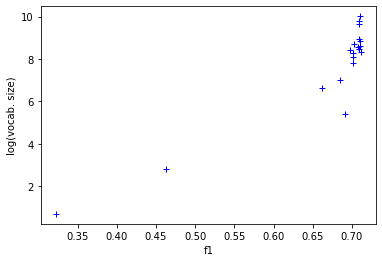

In [8]:
def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)
    
    ### STUDENT START ###
    
    # initialize a new vectorizer and transform training data 
    cv = CountVectorizer()
    fv_train = cv.fit_transform(train_data)

    # set some variables to use for plots
    f1_vals = []
    log_vocab = []
    
    # Initialiaze strength values
    strengths = [500, 250, 175, 100, 75, 50, 40, 35, 30, 25, 20, 15, 10, 5, 1, 0.5, 0.1, .01, .001]
    
    # iterate through each stength value
    for strength in strengths:
        
        # Produce a Logistic Regression model using the L1 regularization strength. 
        l1 = LogisticRegression(C=strength, solver="liblinear", multi_class="auto", penalty="l1", tol=0.015)
        l1.fit(fv_train, train_labels)

        # Get features that have non-zero weights
        nonzero_features = np.nonzero(l1.coef_)[1].tolist()
        nonzero_unique = np.unique(nonzero_features).tolist()

        # Extract vocab with nonzero features
        new_vocab = np.array(cv.get_feature_names())[nonzero_unique]
        
        # Produce a new Logistic Regression model using the reduced vocabulary and L2 regularization strength of 0.5. 
        cv2 = CountVectorizer(vocabulary=new_vocab)    
        fv_train2 = cv2.fit_transform(train_data)
        l2 = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto", penalty="l2")
        l2.fit(fv_train2, train_labels)
        
        fv_dev = cv2.transform(dev_data)
        predicted = l2.predict(fv_dev)

        # Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.
        f1 = metrics.f1_score(dev_labels, predicted, average='weighted')
        print(f'reg. strength: {strength:5}  vocab. size={len(new_vocab):5}  f1={f1:.3}')
        f1_vals.append(f1)
        log_vocab.append(np.log(len(new_vocab)))
        
    # Show a plot of f1 score vs. log vocabulary size. 
    # Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.
    plt.plot(f1_vals, log_vocab, 'b+')
    plt.xlabel('f1')
    plt.ylabel('log(vocab. size)')
        
    ### STUDENT END ###

P6()

ANSWER:

_How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?_

> The performance of the model seems relatively consitent at about 0.71 once the C value gets to 5. As the C value decreaes from there performance droppes of significantly.

### Part 7:

How is `TfidfVectorizer` different than `CountVectorizer`?

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

Show the 3 documents with highest R ratio, where ...<br/>
$R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$

Explain what the R ratio describes.  What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

In [9]:
def P7():
    ### STUDENT START ###
    
    # Transform data
    tv = TfidfVectorizer()
    fv_train = tv.fit_transform(train_data)
    fv_dev = tv.transform(dev_data)
    
    # Fit model.
    lr = LogisticRegression(C=100, solver="liblinear", multi_class="auto")
    lr.fit(fv_train, train_labels)
    predictions = lr.predict(fv_dev)
    probabilities = lr.predict_proba(fv_dev)
    
    # Create R ratios: maximum predicted probability / predicted probability of correct label
    ratio_values = np.array([probabilities[i,predictions[i]]/probabilities[i,dev_labels[i]] for i in range(len(dev_labels))])
    
    # Get top 3 and display results
    indices = ratio_values.argsort()[-3:][::-1]
    sep = '=' * 40

    for i in indices:        
        print(sep)
        print("Correct Label: ",newsgroups_train.target_names[dev_labels[i]])
        print("Predicted Label: ",newsgroups_train.target_names[predictions[i]])
        print("Ratio: ", round(ratio_values[i],2))
        print(sep)
        print(f'{dev_data[i]}\n\n')        

    
    return indices 

    ### STUDENT END ###

P7()

Correct Label:  talk.religion.misc
Predicted Label:  comp.graphics
Ratio:  929.36
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (paper, copy center charges), but may not charge
anything for their time in making copies, or in any way realize a profit
from the use of this bo

array([215, 665, 607])

ANSWER:


_1. How is TfidfVectorizer different than CountVectorizer?_

> CountVectorizer counts the word frequencies, the Tf-idf (term-frequency times inverse document-frequency) value increases proportionally to count and it is offset by the frequency of the word vocabulary. Tfidf Vectorizer limits the impact of words that have high frequency.

_2. What does the R ratio describe?_

> 𝑚𝑎𝑥𝑖𝑚𝑢𝑚 𝑝𝑟𝑒𝑑𝑖𝑐𝑡𝑒𝑑 𝑝𝑟𝑜𝑏𝑎𝑏𝑖𝑙𝑖𝑡𝑦 ÷ 𝑝𝑟𝑒𝑑𝑖𝑐𝑡𝑒𝑑 𝑝𝑟𝑜𝑏𝑎𝑏𝑖𝑙𝑖𝑡𝑦 𝑜𝑓 𝑐𝑜𝑟𝑟𝑒𝑐𝑡 𝑙𝑎𝑏𝑒𝑙; i.e. the distance between the probability of the prediction vs the actual probability of the true label. The closer to 1 the ratio the more wrong / far off was the model from the correct answer.

_3. What kinds of mistakes is the model making?_

> For the first two cases it seems that it weighs the abundance of words relating to 'publishing' higher than the word 'Mormon' despite the fact that it is mentioned three times

_4. A way to address one particular issue that you see._

> The performance may theoretically improve if we set a minimum threshold. This way the 'publishing' related words will lose some of its importanc as they do not occur as frequently as the word 'Mormon'.

### Part 8 EXTRA CREDIT:

Produce a Logistic Regression model to implement your suggestion from Part 7.